# Score-based Generative Models -- LOGBOOK

Student: Prithvi Raj, pr478@cam.ac.uk

Supervisor: Prof. Mark Girolami

IIB Project Code: D-mag92-1

Please read my [project brief](https://github.com/PritRaj1/IIB-Project-ScoreNets/blob/main/Notebooks/Prithvi_Project_Proposal) for more context. I worked hard on it!

## Summer

Over summer, I briefly read the following papers:

- [[1605.08803] Density estimation using Real NVP](https://arxiv.org/abs/1605.08803)
- [[1907.05600] Generative Modeling by Estimating Gradients of the Data Distribution](https://arxiv.org/abs/1907.05600)
- [[1807.03039] Glow: Generative Flow with Invertible 1x1 Convolutions](https://arxiv.org/abs/1807.03039)

Given my unfamiliarity, I supplemented my understanding with the authors’ corresponding blog posts. I also explored the structure of their repositories, as well as Justin’s exemplar repositories, to better understand how to structure any machine learning codebases. 

As an exercise, I reorganized the tutorial on the score-based Stochastic Differential Equation (SDE) model, which was featured in a Colab notebook in the blog post below. This helped solidify my understanding of how professional research repositories are structured.

[Generative Modeling by Estimating Gradients of the Data Distribution | Yang Song (yang-song.net)](https://yang-song.net/blog/2021/score/)

My reorganised version can be found here: https://github.com/PritRaj1/Modularised-Score-based-SDE-Tutorial.git


## Michaelmas -- Ramping Up and Learning

### 03/10/2023

Following the preliminary readings completed over summer regarding basic ideas in generative modelling, as well as the review of standard codebases and modular coding practices, today was dedicated towards reading around expectation maximisation, mixture models, and denoising diffusion models. I also began my implementation of a simple diffusion model. After struggling with this for some time, I have arranged a meeting with Justin, (a researcher in Prof. Girolami's lab), in two days time.

### 05/10/2023

Attended meeting with Justin and have developed a better understanding of how to implement the denoising diffusion model presented in this paper: [[2006.11239] Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)

Spent some time updating the notebook in the evening, however it is still not working. The forwards diffusion process works correctly, but I suspect the problem is either in my neural network or in the reverse diffusion process. Although it is difficult to determine which one, since samples are being generated but are appearing as incoherent noise.

Here is a plot of the forwards diffusion in practice on the sklearn.make_moons dataset:

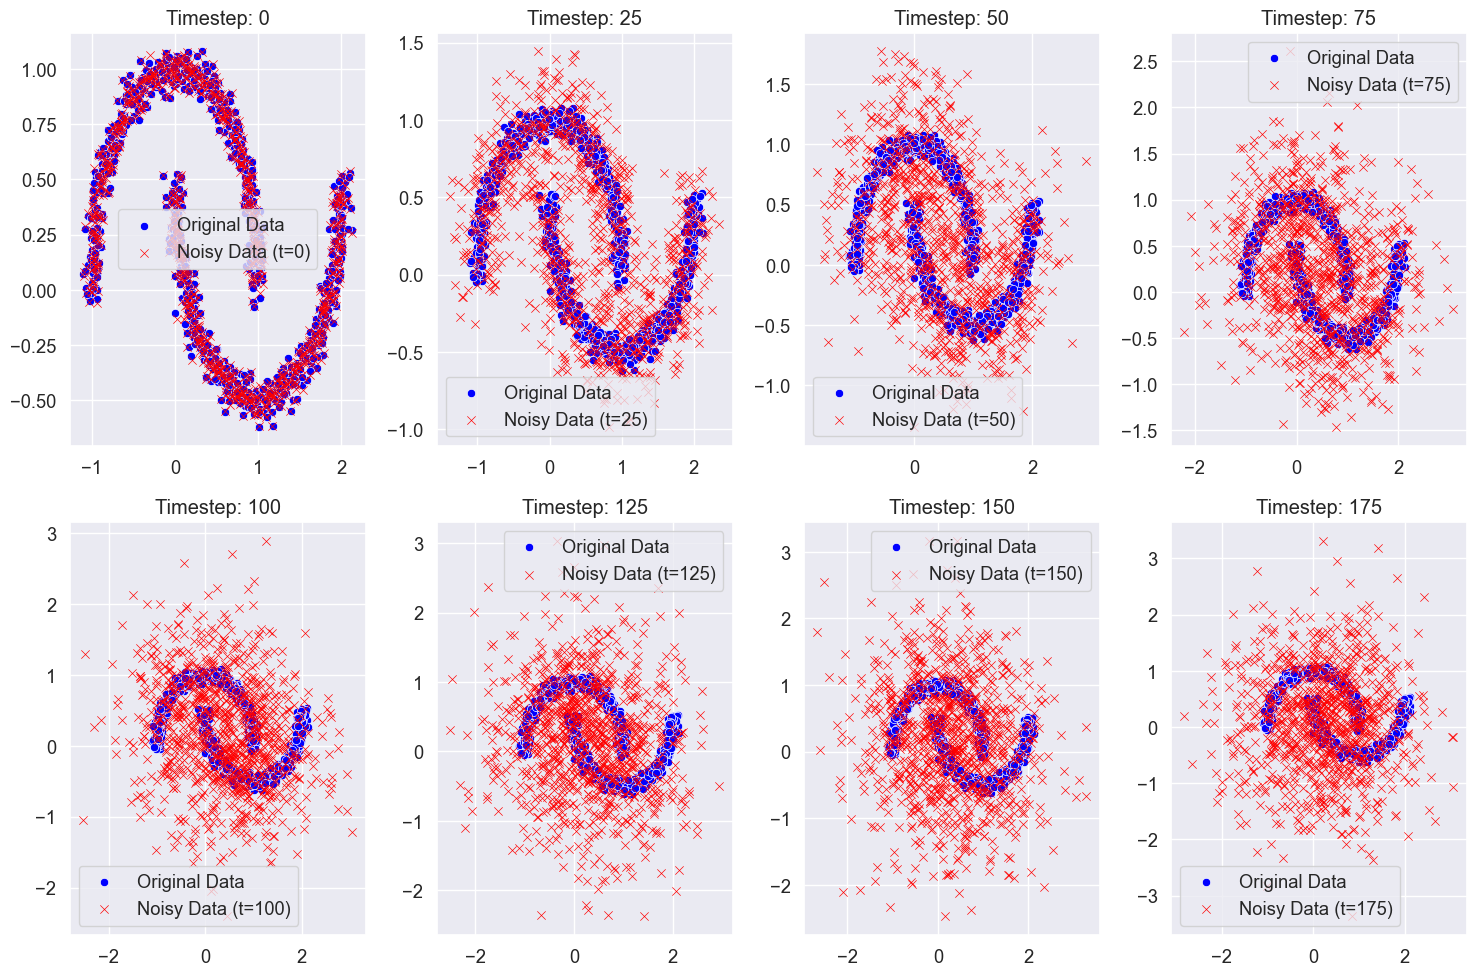

### 06/10/2023

Spent more time on the notebook, but am having problems with 'cuda' device errors. Need to look over again - it is very difficult to determine the cause given the parallel nature of CUDA programming. I have also noticed that tensorboard is not opening - instead I have elected to plot samples manually, but will need to solve this for future tries.

### 07/10/2023

The notebook is now generating samples -- device/shape errors all resolved. Unfortunately they look nothing like the sklearn.make_moons dataset, (incoherent noise). 

### 11/10/23

After a supervison-style meeting with Justin, the denoising diffusion notebook now works correctly, can be found [here](https://github.com/PritRaj1/IIB-Project-ScoreNets/blob/main/Notebooks/DenoisingDiffusionModel.ipynb). Unfortunately, we both could not get tensorboard working on my laptop - will try reinstalling packages at home. 


### 12/10/23 

Started working on the denoising score model. It generates samples and seems to be learning something, but looks nothing like the make_moons dataset.

### 13/10/23
I implemented batching into the denoising diffusion model, which greatly improved the model's performance on the make moons test data. Below is an image of the model learning how to generate new make_moons data.

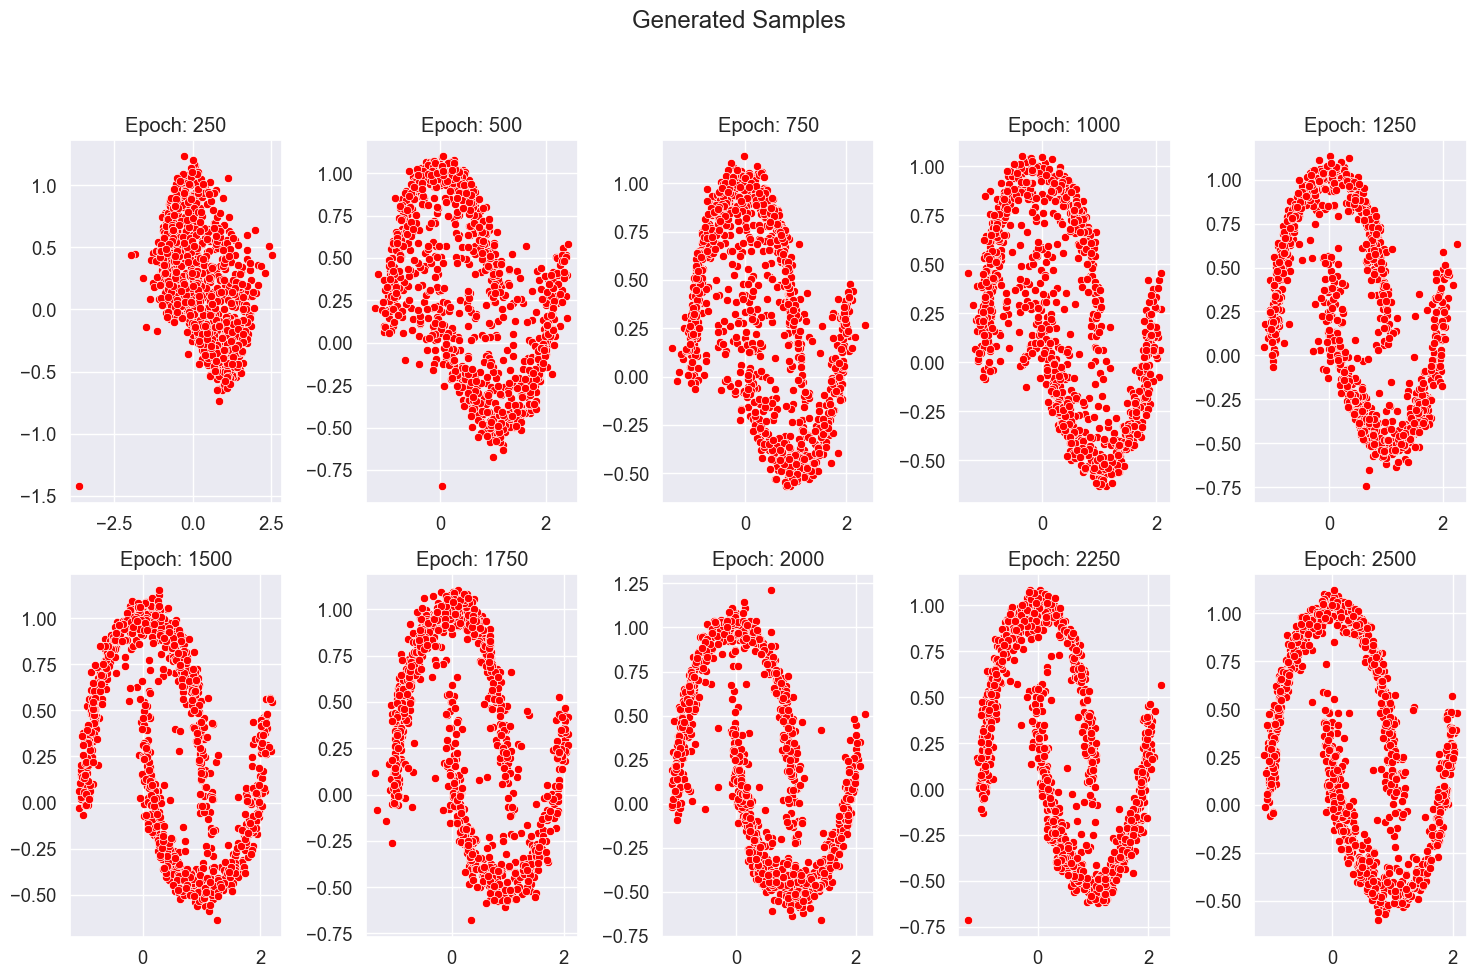

I also kept working on the denoising score mqtching model. Unfortunately, I'm running into CUDA device errors at the langevin sampling step - I suspect due to the indexing script I created to generate noise in the langevin update step.

### 16/10/23

Kept going with the denoising score matcher, but it is not generating coherent make_moon data. Have tried varying the number of samples, learning rate, timesteps, etc. but to no avail, suggesting that the problem is within my implementation of the paper's fundamental ideas. Prof. Girolami has also sent me a [new paper](https://arxiv.org/abs/2006.08205) to look over, specifically about a Latent Space Energy-Based Prior Model developed at UCLA. I would ideally like to get the denoising score model implemented before attempting to reinterpret this model in PyTorch. Therefore, I am setting a deadline for the score matching model to be finished by Wednesday.

P.S. whenever I reference the model generating "incoherent" samples, or samples that look nothing like the make_moons dataset, they look something like this:

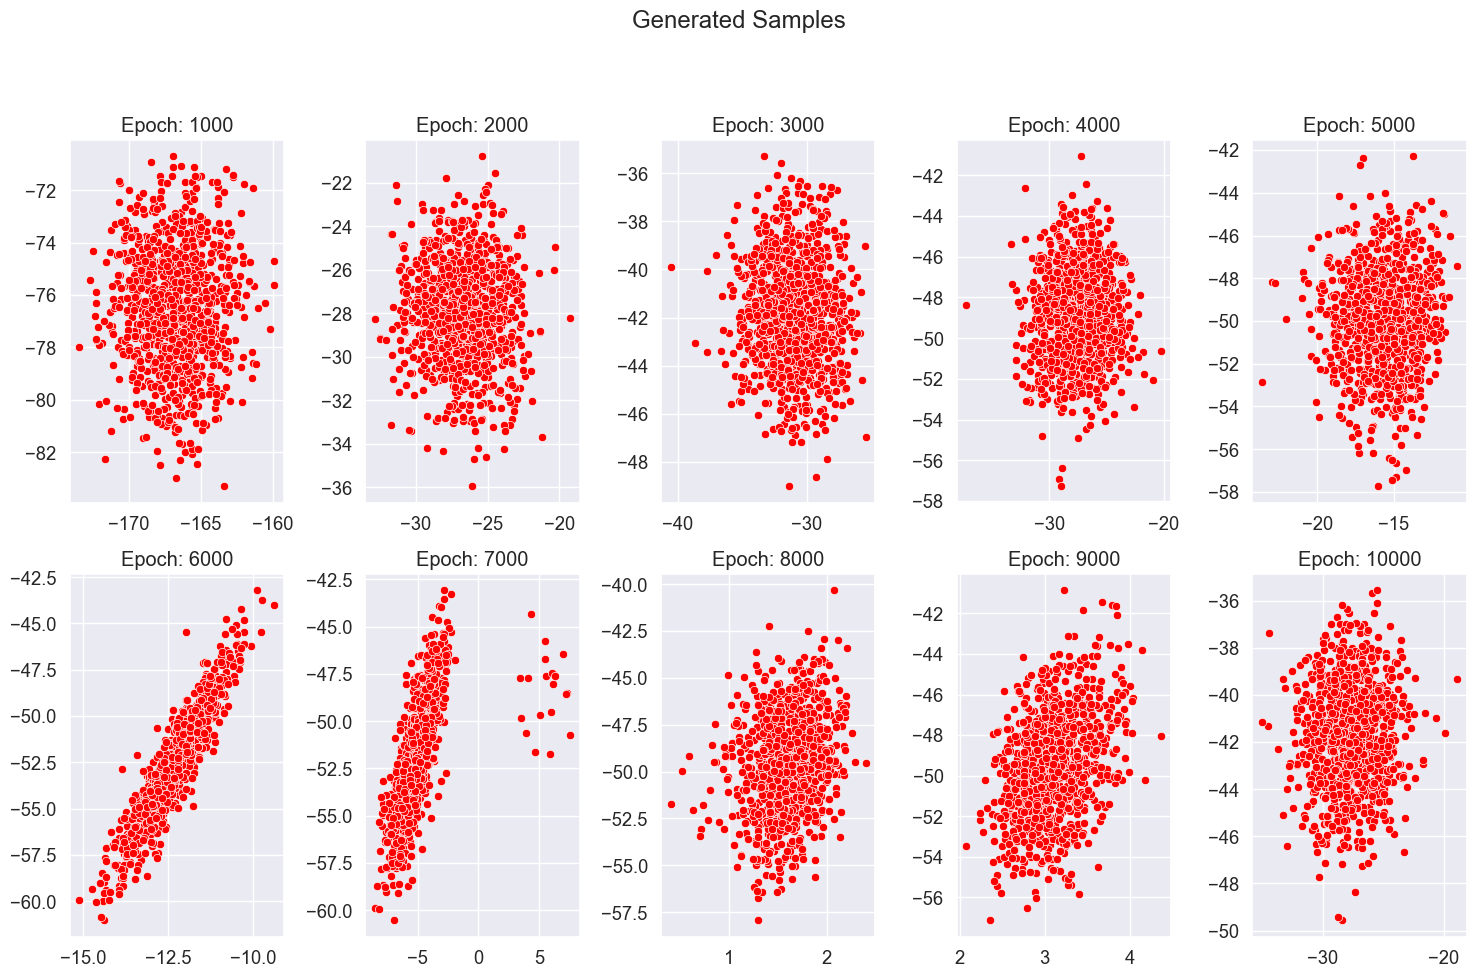

### 17/10/23

The denoising score-matching model has now been implemented correctly, and can be found [here](https://github.com/PritRaj1/IIB-Project-ScoreNets/blob/main/Notebooks/DenoisingScoreModel.ipynb). The ideas were implemented correctly - the problem was in the hyperparameters. After lots of tuning, the model successfully reproduced the make_moons dataset, as shown in this example:

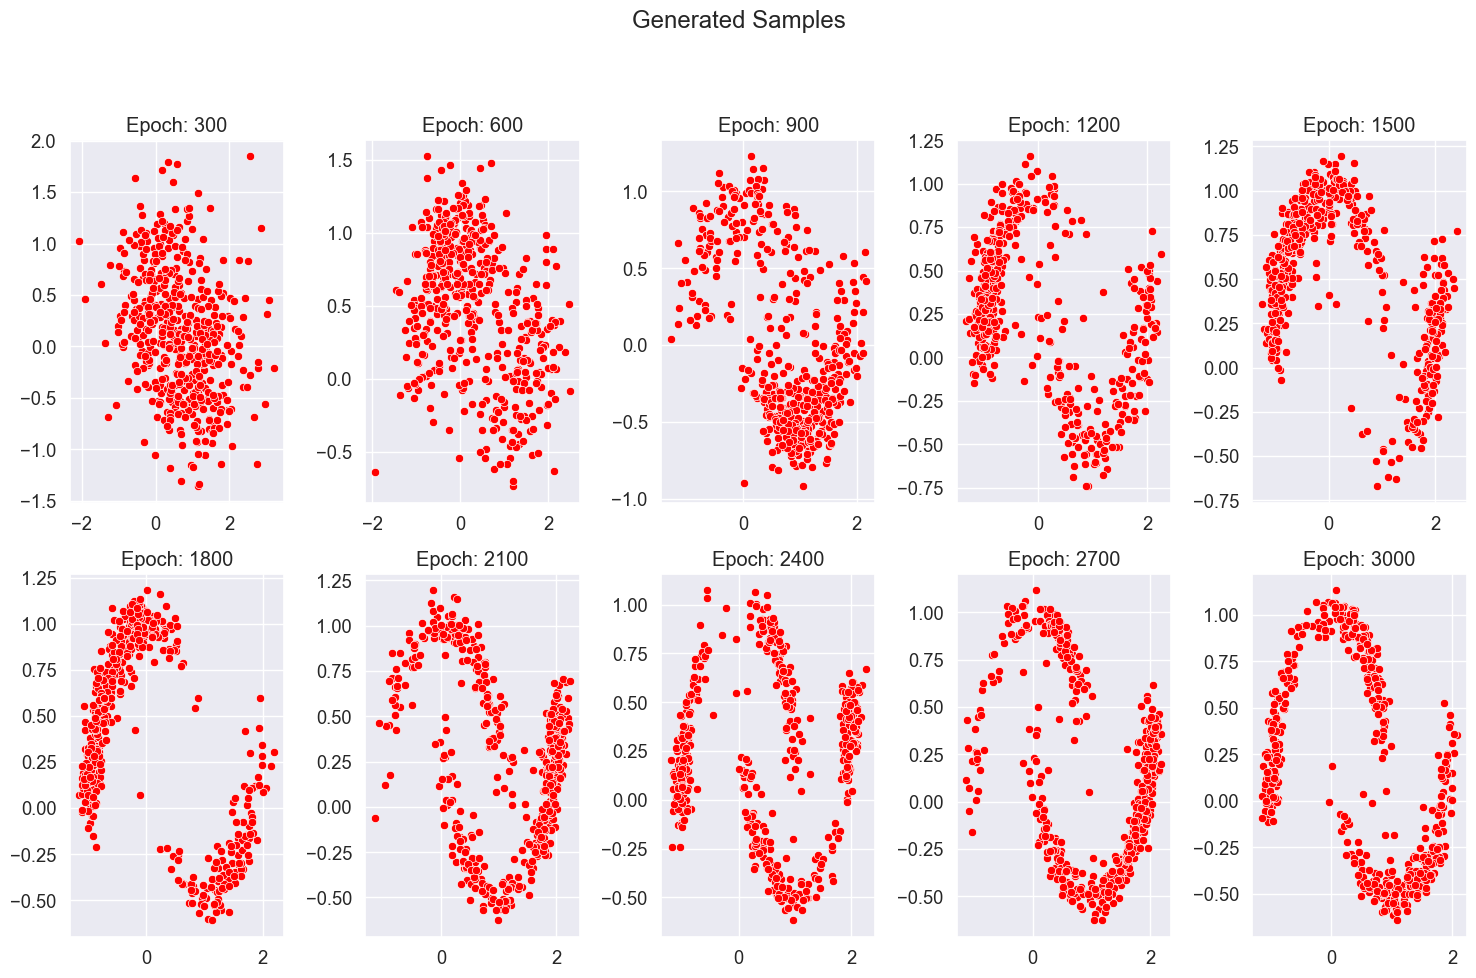

The hyperparameters used were as follows:

- EPOCHS = 3000
- PERTURBATIONS = 100
- TIMESTEPS = 100
- SAMPLES = 1000
- EPSILON = 1e-6
- LR = 1e-3
- BATCH_SIZE = 128
- SIGMA_RANGE = (0.001, 10)

They key ideas I have learnt through this stage of the project was the importance of hyperparameter tuning, and the importance of batching. I also learnt about latent-space modelling, which will be very important going forwards. 

The largest benefit was thinking about how to create desired distributions by directly manipulating the random variable that they govern. For example, here is the class used to manipulate the mean/variance of the data to create a latent variable sample:

```python
class Diffuser:
    def __init__(self, num_perturbations, sigma_range=(0.01, 0.5), device='cuda'):
        self.device = device
        self.perturbations = num_perturbations
        numpy_sigmas = torch.from_numpy(np.geomspace(sigma_range[0], sigma_range[1], num_perturbations))
        self.sigmas = numpy_sigmas.flip(0).float().to(device)
        
    def forwards_diffusion(self, x0, t):

        # 1. Sample from the standard gaussian --> mean = 0, var = I
        noise = torch.randn_like(x0, device=self.device)

        # 2. Multiply to change standard deviation --> mean = 0, var = sigma**2 * var(noise) * I
        std_dev = self.sigmas[t] * noise

        # 3. Perturb sample
        sample = x0 + std_dev
        
        return sample.float(), self.sigmas[t]
```

Another key idea is the idea of sampling from an intractable probability distribution with MCMC. The main idea is to sample my latent variable from a standard Gaussian distribution, and then perturb the sample with a Langevin update step, (denoising). This is done for a number of timesteps, and the final sample is then returned as the 'original-space' variable. This is implemented in the following class:

```python
class Sampler:
    def __init__(self, epsilon, timesteps, num_samples, device='cpu') -> None:
        self.device = device
        self.eps = torch.tensor(epsilon, device=self.device) 
        self.timesteps = timesteps
        self.samples = num_samples
    
    def sampling_loop(self, model, diffuser):

        # Get the final sigma
        sigma_T = diffuser.sigmas[-1]
        
        # Take the latent from the standard Gaussian distribution
        x_t = torch.randn(size=(self.samples, 2), device=self.device)
        
        with torch.no_grad():
            # For each noise
            for i in range(diffuser.perturbations):
                tensor_step = torch.ones(self.samples, 1, device=self.device, dtype=torch.int) * i
                
                # Extract the noisy step size
                alpha_i = self.eps * (diffuser.sigmas[i]/sigma_T)**2

                # Paper notation: for t in T
                for t in range(self.timesteps):
                    
                    # Sample from standard gaussian
                    z = torch.randn_like(x_t, device=self.device)

                    # Langevin update step
                    x_t = x_t + ((alpha_i/2) * model(x_t, tensor_step)) + (torch.sqrt(alpha_i) * z)

        return x_t
```

## Michaelmas -- Focused Project Kick-off

### 24/10/23

The past week was spent creating and refining a formal project brief. This can be found [here](https://github.com/PritRaj1/IIB-Project-ScoreNets/blob/main/Notebooks/Prithvi_Project_Proposal).

This brief also details some optimistic milestones, although I am aware that these may be subject to change, given the large amount of coursework deadlines and other commitments I have later this term.

### 29/10/23

Following the project brief write-up, I am now attempting to implement Pang's latent EBM-Generator model as a Juypter notebook. I am writing it up myself, because I believe that this will help me understand the model better. I have also been reading around the topic of energy-based models, and have found this [EBM Training Paper](https://arxiv.org/abs/2101.03288) to be particularly helpful.

### 1/11/23

Unfortunately, the latent EBM-Generator model is not producing samples as intended. I have tried varying the learning rate, number of epochs, and number of samples, but to no avail. I suspect that the problem is in the implementation of the model's fundamental ideas, rather than in the hyperparameters, so I will need to verify each of the model's subcomponents against the paper.

### 5/11/23

I implemented a notebook sepcifically to verify my Langevin sampling implementation. In this notebook I samples from a satndard Gaussian and plot a histogram of these samples to verify their distribution. I also plot the markov chain evolution with iteration to verify convergence. This notebook can be found [here](https://github.com/PritRaj1/IIB-Project-ScoreNets/blob/main/Notebooks/Langevin.ipynb) and it produced the following results:

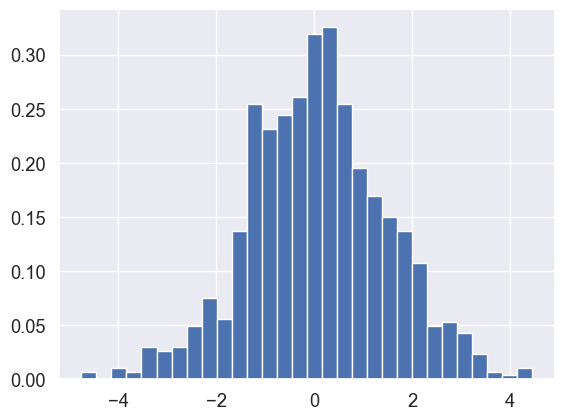
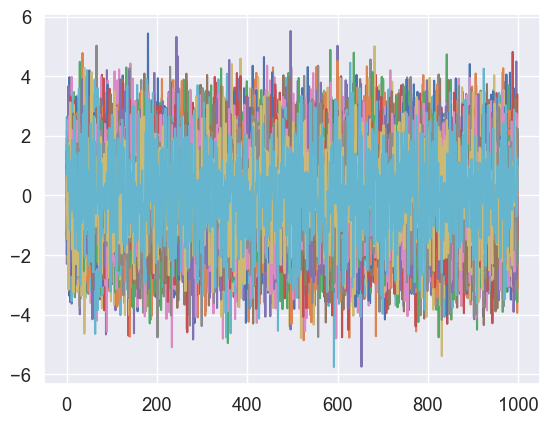

Clearly the Langevin sampler I have implemented as an invariant Python class is working. I call it 'invariant', because it is agnostic to the target distribution I am trying to recreate, i.e. it should work for both the posterior and prior in my model, since the difference between the two, (the grad-log-fn), is passed into the sampler as an external function. Meaning the problem must be in another part of my implmentation. I suspect the grad-log-functions, but will need to verify this against the paper again.

### 7/11/23

Over the past week, I have been trying various implementations of the model to no avail. Here is an exemplar failure to reproduce the make_moons dataset:

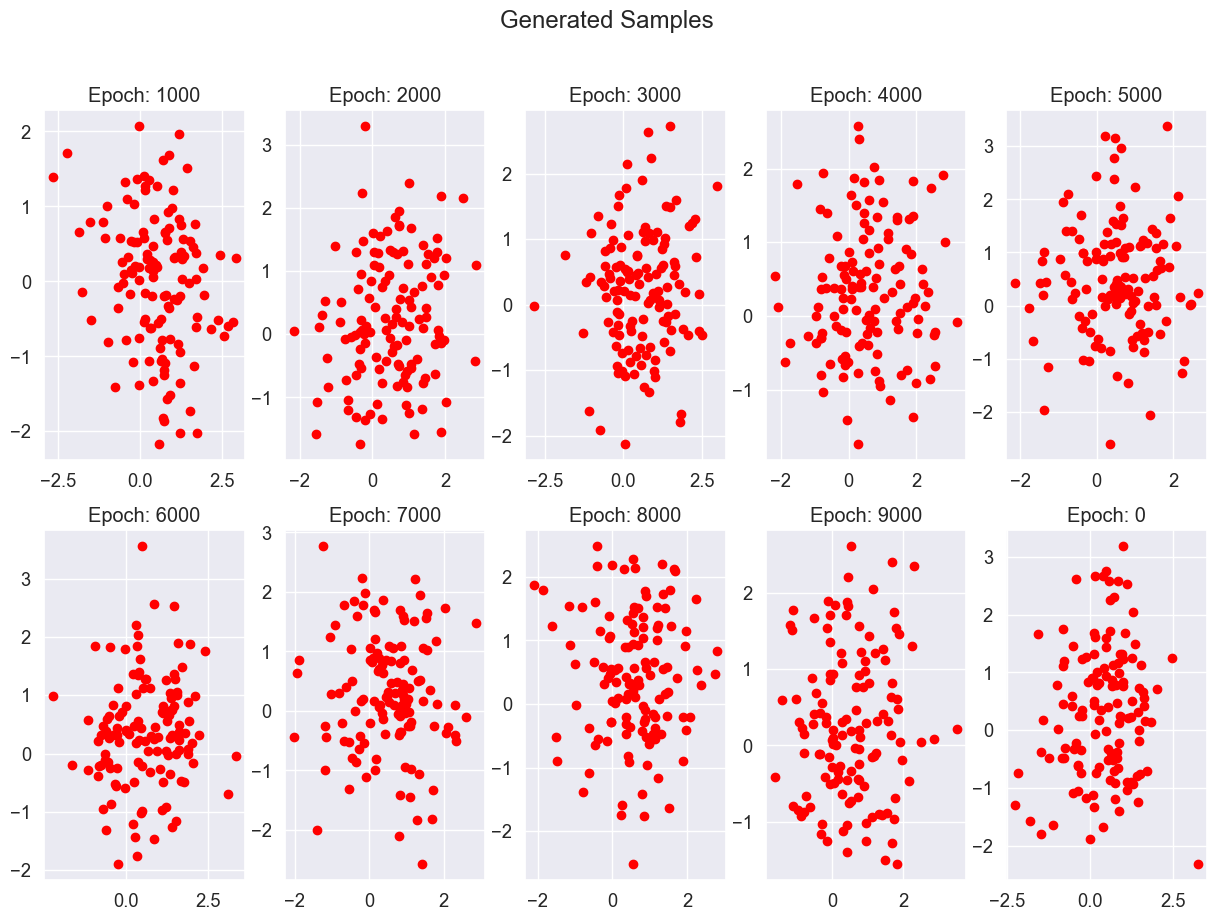

Here is an attempt where I simplified the problem by removing the exponentially-tilted Gaussian prior, and instead just using a white noise prior. This also failed:

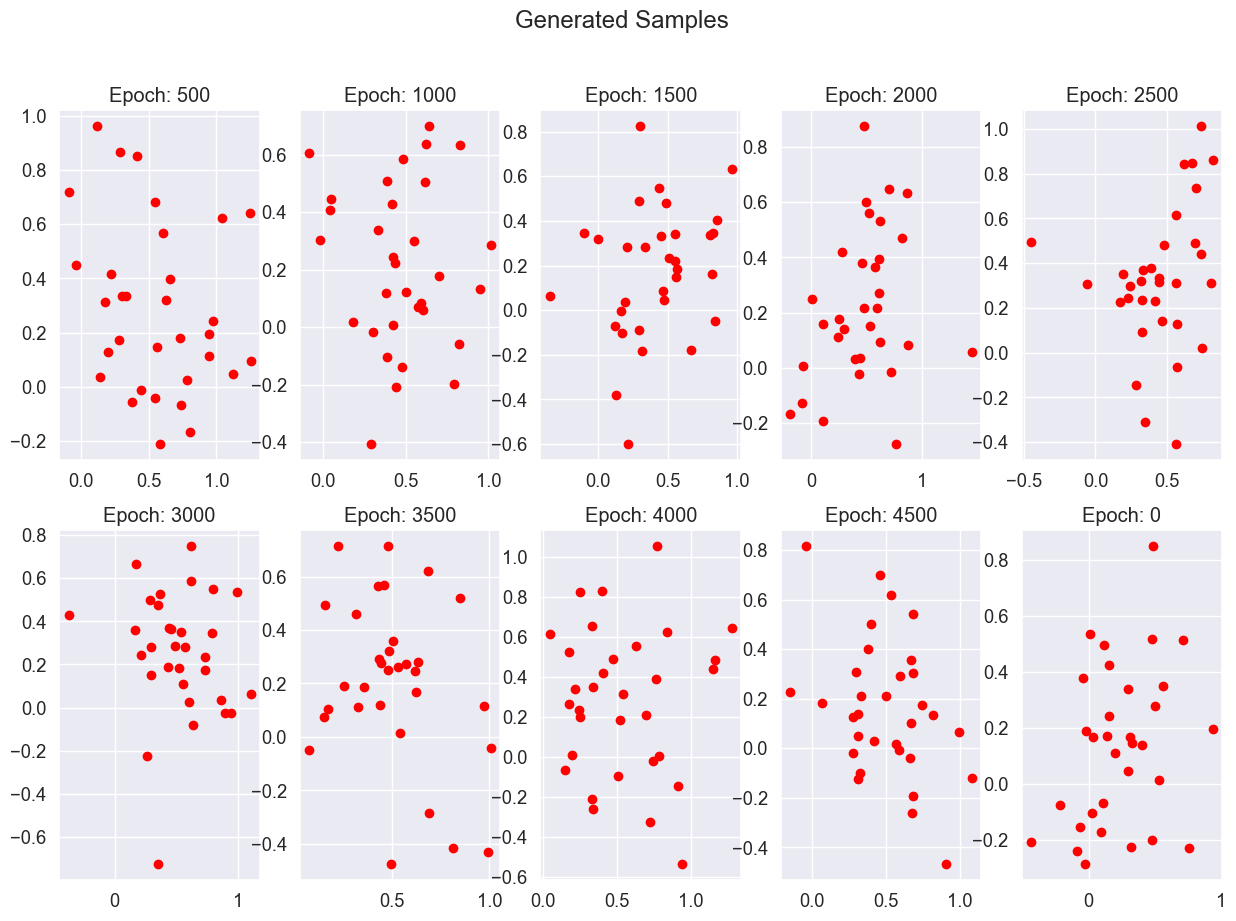

Here is an attempt on sklearn's make_moons dataset which also failed, (this version of the implementation was very unstable and could only run for a limited number of iterations):

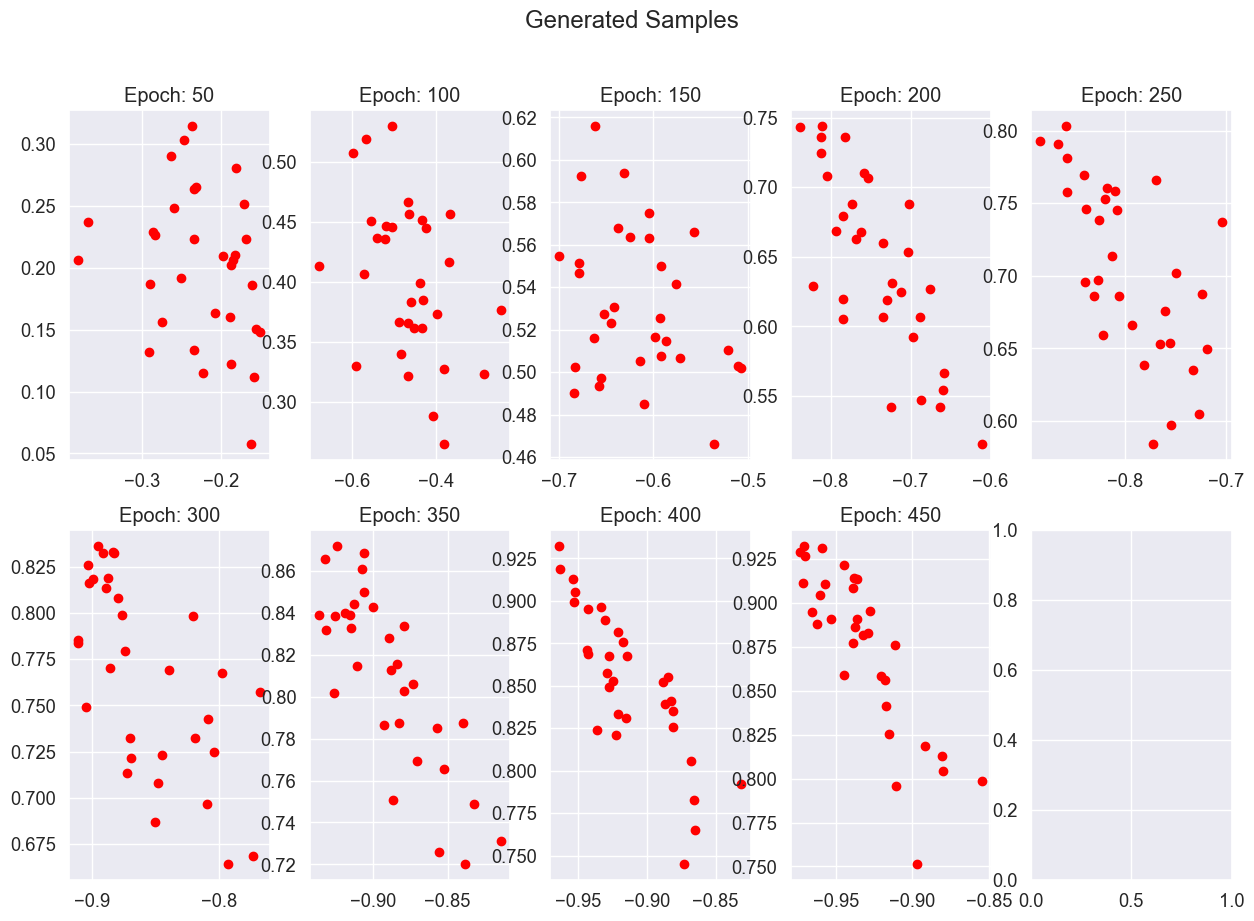

The above was interesting because it shows that the model is learning something, but it is not learning the make_blobs dataset. Instead, it is convergin onto a different distribution, which is not what we want. This suggests that the problem is in the implementation of the model's fundamental ideas, rather than in the hyperparameters. To verify this I've plotted a histogram of the latent variable samples (left is white-noise prior, right is generated by the models):

 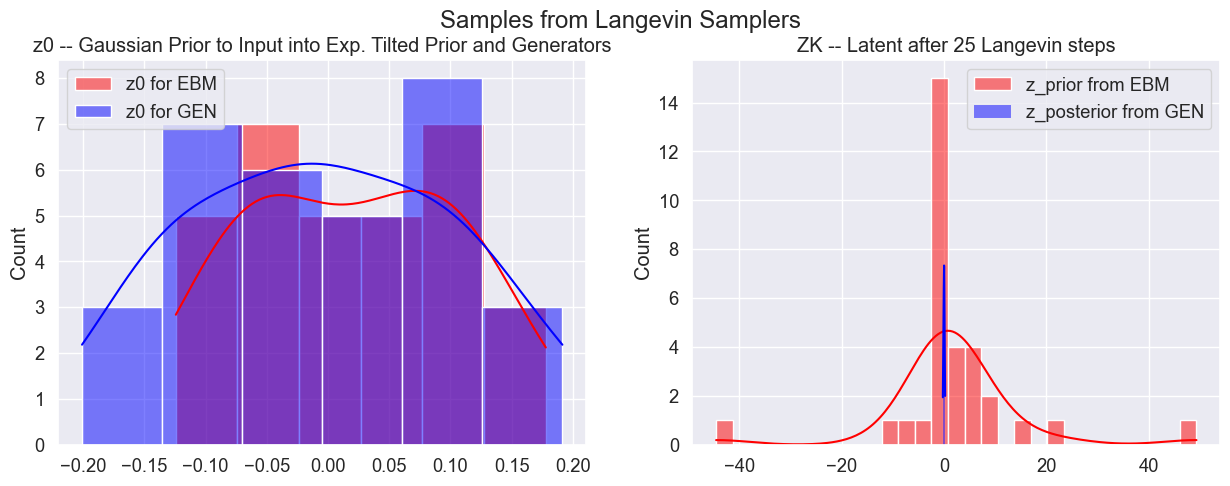

 As you can see, the posterior distribution $p_\theta(z|x)$ is being squeezed into a dirac-delta distribution, which explains the instability I was seeing. Ideally, the model should be matching $p_\alpha(z)$ to $p_0(z)$, and the posterior-distribution should therefore be wider spread given that it is proportional to $p_\theta(x|z)p_\alpha(z)$. Clearly, there's more to be refined in my code. I will need to verify each of the model's subcomponents against the paper.

 ### 8/11/23

 I've replaced parts of my written code, (particularly the grad-log-fn's), with Pang's given code from the paper. However, after realising that there was a typo in the paper-provided code, I instead switched to the code provided by Pang's GitHub. Both still failed to produce samples, however through this troubleshooting, I have greatly developed my understanding of the model's ideas. I going to retry next week with my own implementation, (given that I do not like Pang's coding style), and will verify each of the model's subcomponents with histograms and kernel density estimates. 

### 13/11/2023

The code has been overhauled, and I much prefer its implementation over Pang's. Moreso than anything else, it's much easier for me to troubleshoot. I have also verified each of the model's subcomponents against the paper, and they all seem to be working correctly. However, the model is still not producing samples.This time, however, I am confident that the problem is in the hyperparams. I will spend tomorrow investigating this. Also, as a brief aside that I forgot to mention previously, tensorboard is now working correctly. I have also started using tensorboard profiler to help me identify bottlenecks in my code.

### 14/11/2023

After refining the latent EBM-generator model further, and training it on a simpler dataset, (sklearn's make_blobs, featuring 2 clusters), the model has finally exhibited some form of convergence. The model was with the following HPs:

- NUM_EPOCHS = 20000
- BATCH_SIZE = 128
- DATA_SAMPLES = 4000
- Z_SAMPLES = 2
- E_LR = 0.00002
- G_LR = 0.0001
- E_STEP = 0.4
- G_STEP = 0.1
- E_SAMPLE_STEPS = 20
- G_SAMPLE_STEPS = 20
- p0_SIGMA = 0.5
- GENERATOR_SIGMA = 0.3

And the following trainig data points were produced:

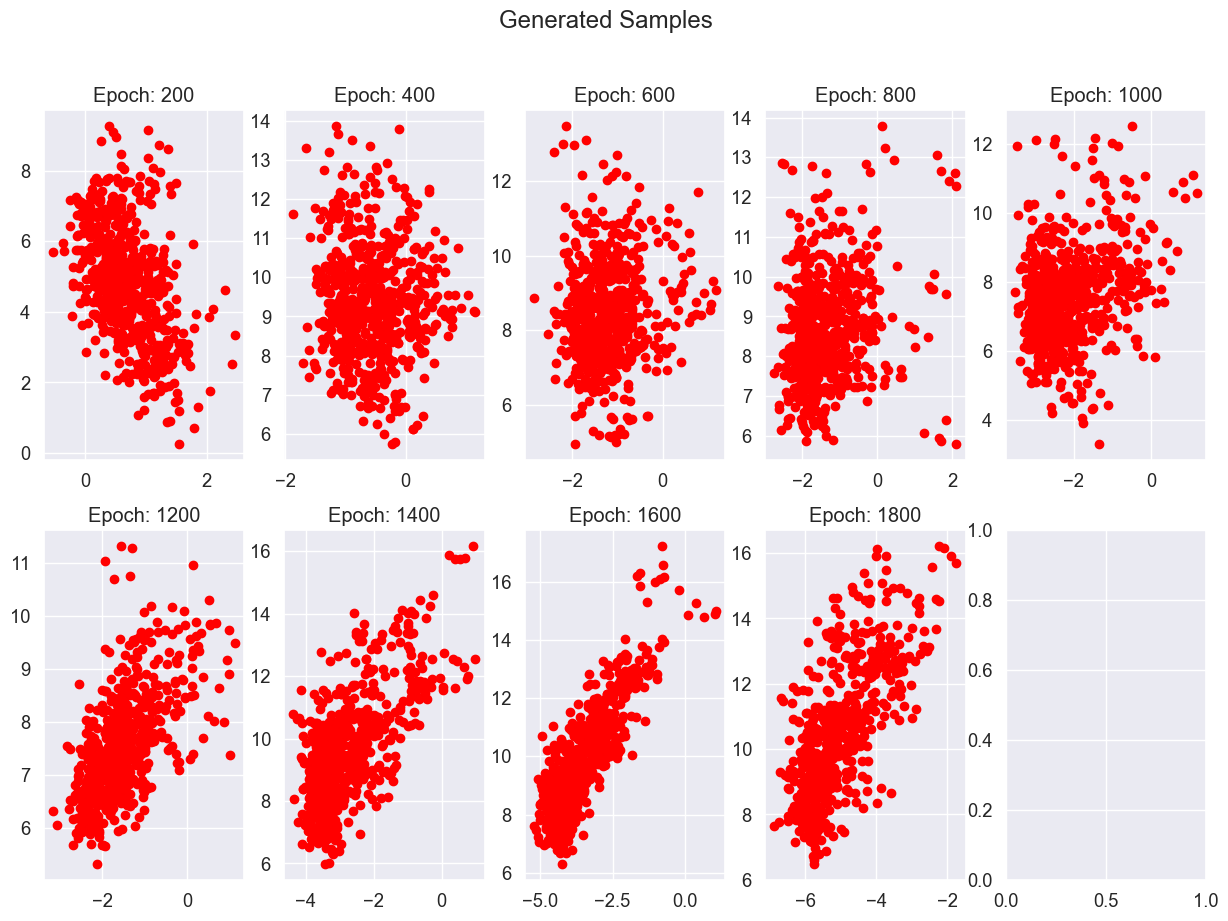

Looking at the resulting histogram of data points density, once can see that the model seems to have learnt two modes in the data distribution:

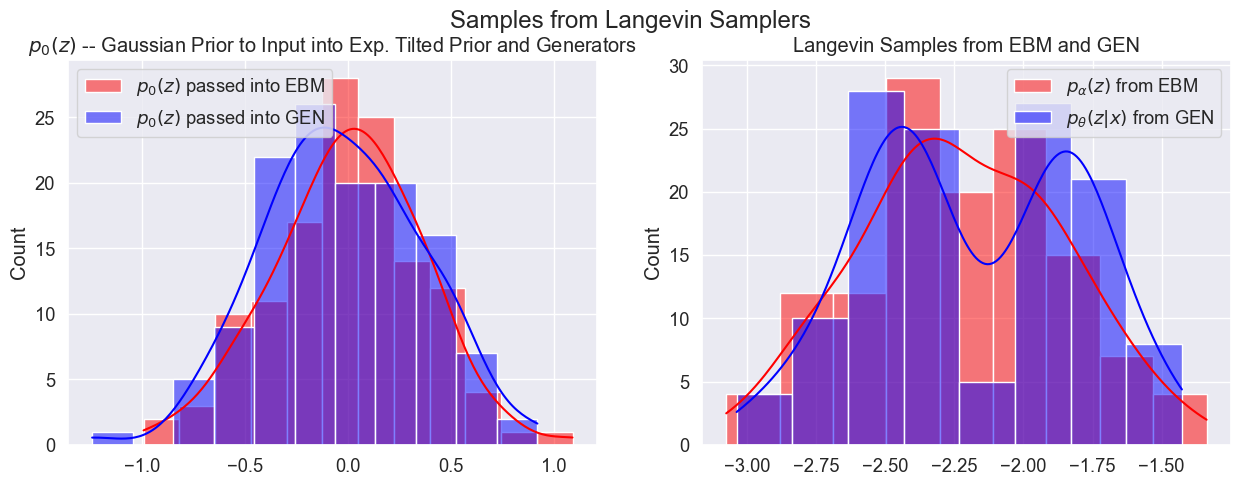

A plot of the resuling kernel density estimates would reinforce this:

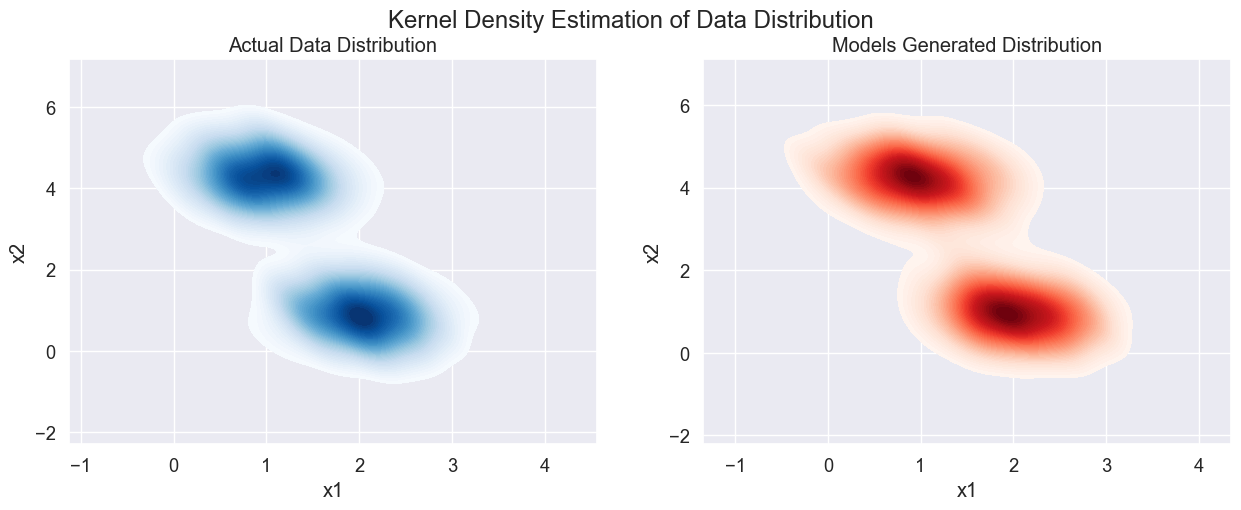

Training on the make_moons dataset with the same hyperaparameters produced the following results:

Training:

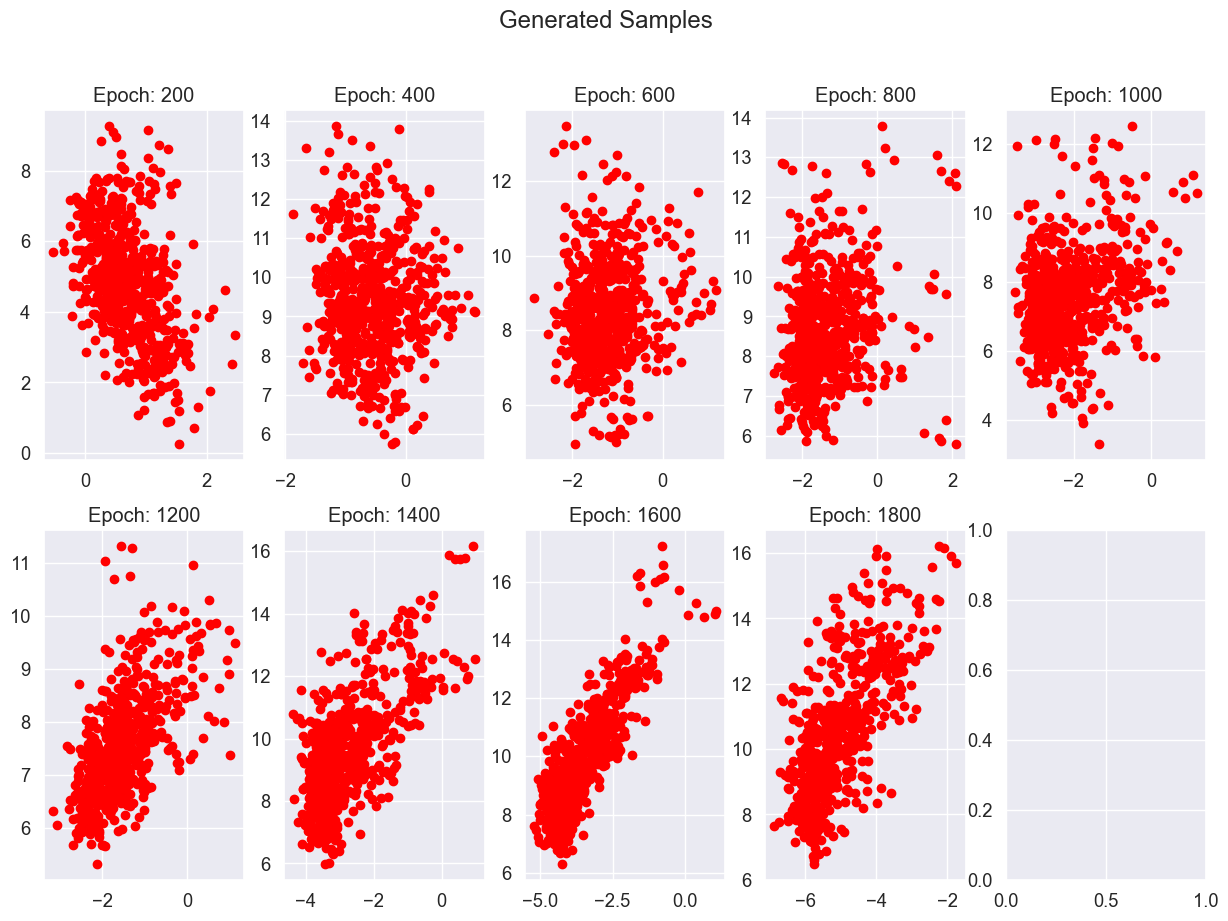

Histogram:

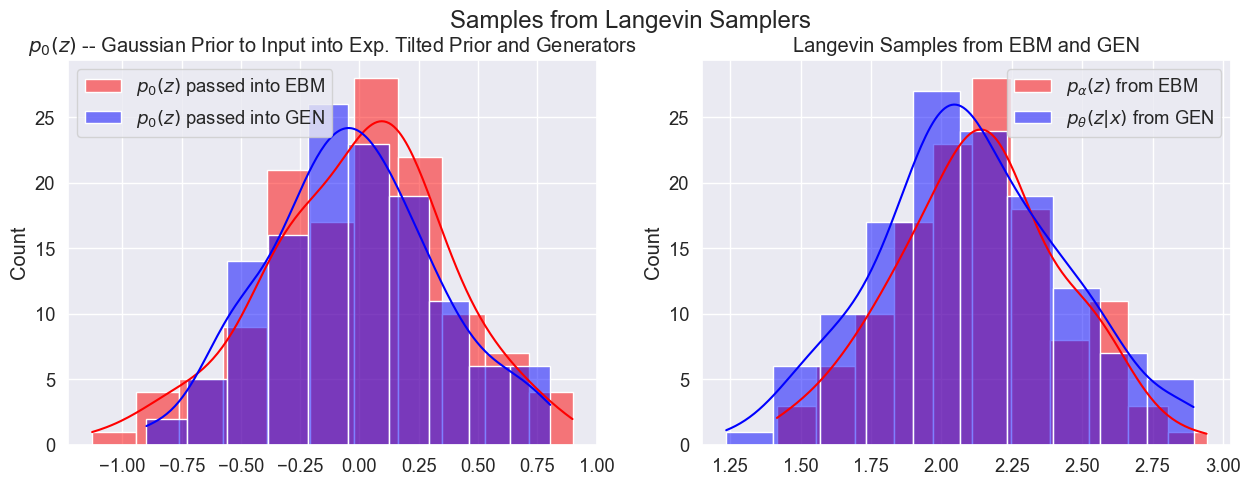

Kernel Density Estimates:

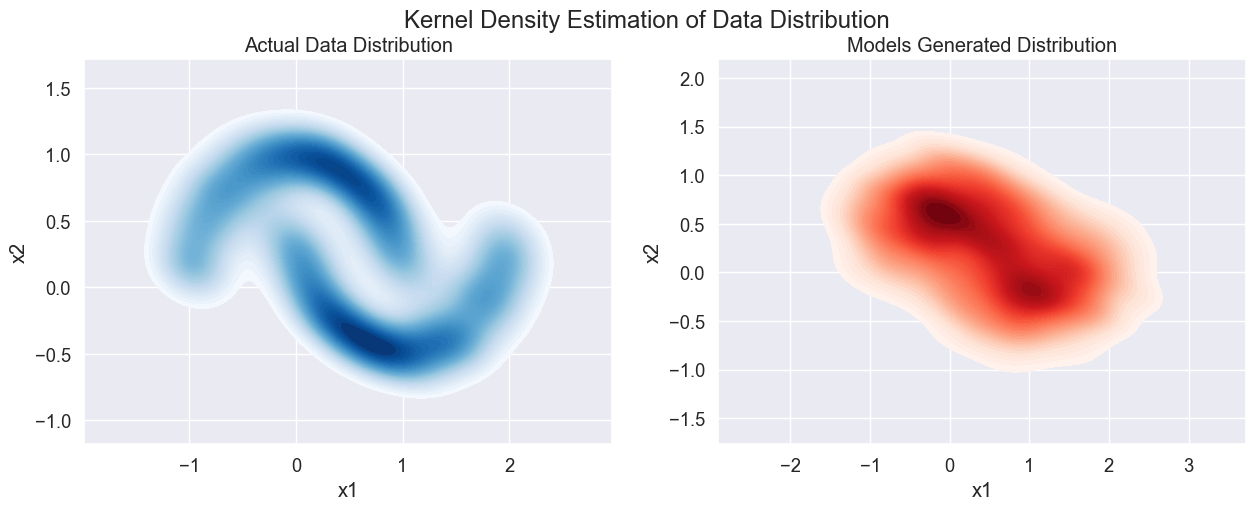

Clearly, the model is learning correctly. The histogram plots show how the EBM is trying to match $p_\alpha(z)$ to $p_\theta(z|x)$ and two modes are beginning to form in the case of the make_blobs dataset. The kernel density estimates also show that whilst the plotted samples do not look like they are converging to the distributions, their marginal likelihoods are converging to look similar to the datasets. This is a good sign, and suggests that the model is learning correctly, but need more time in the oven/learning rate tuning.

### 15/11/2023

The model has been fine-significantly and now, I am plotting histograms for both generated samples using z from the prior and generated samples using z from the posterior. The hyperparams have now been set to:


- NUM_EPOCHS = 100
- BATCH_SIZE = 32
- DATA_SAMPLES = 2000
- Z_SAMPLES = 2
- E_LR = 0.0002
- G_LR = 0.001
- E_STEP = 0.2
- G_STEP = 0.1
- E_SAMPLE_STEPS = 80
- G_SAMPLE_STEPS = 80
- p0_SIGMA = 0.2
- GENERATOR_SIGMA = 0.1

The following results were obtained:

Training:

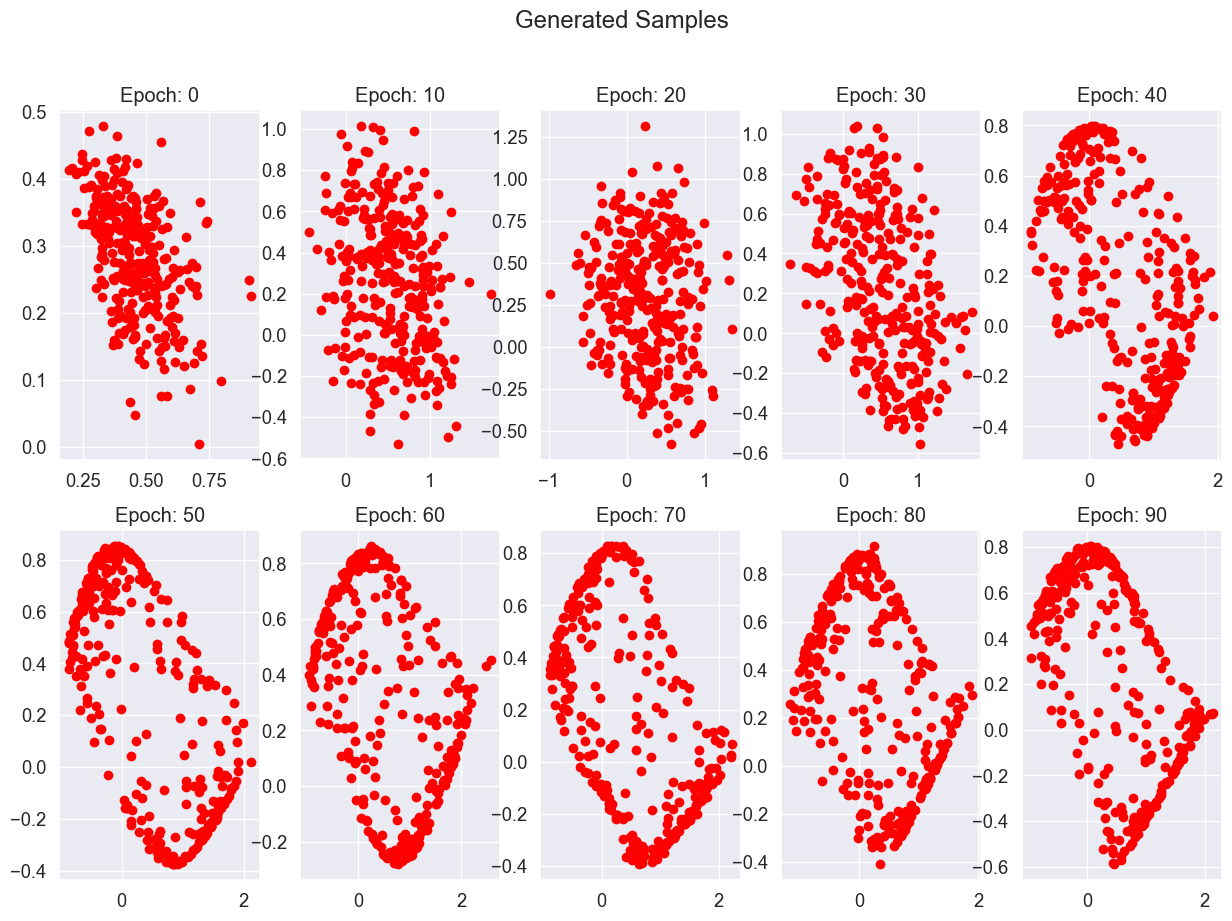

Metrics:

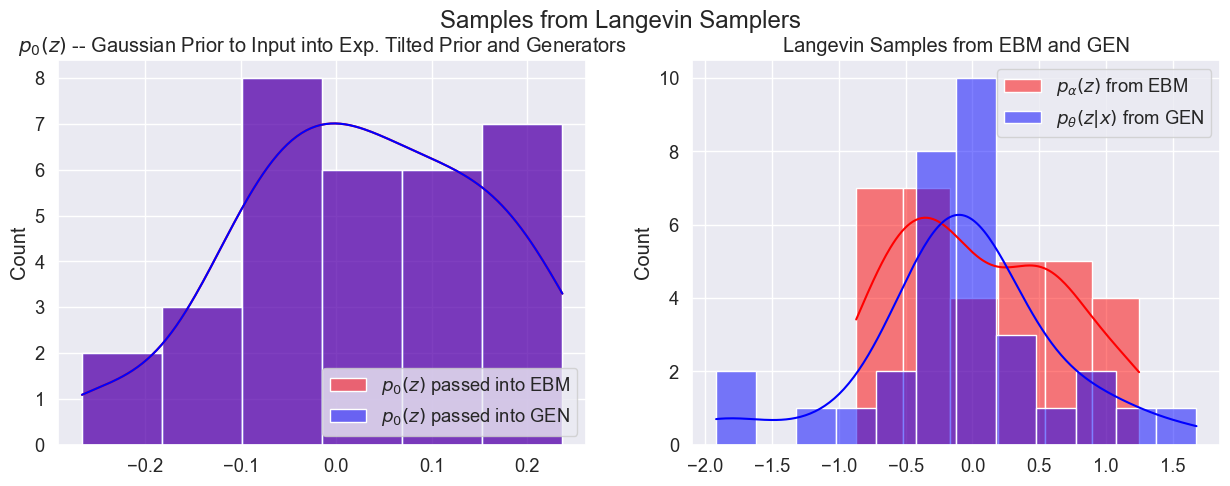
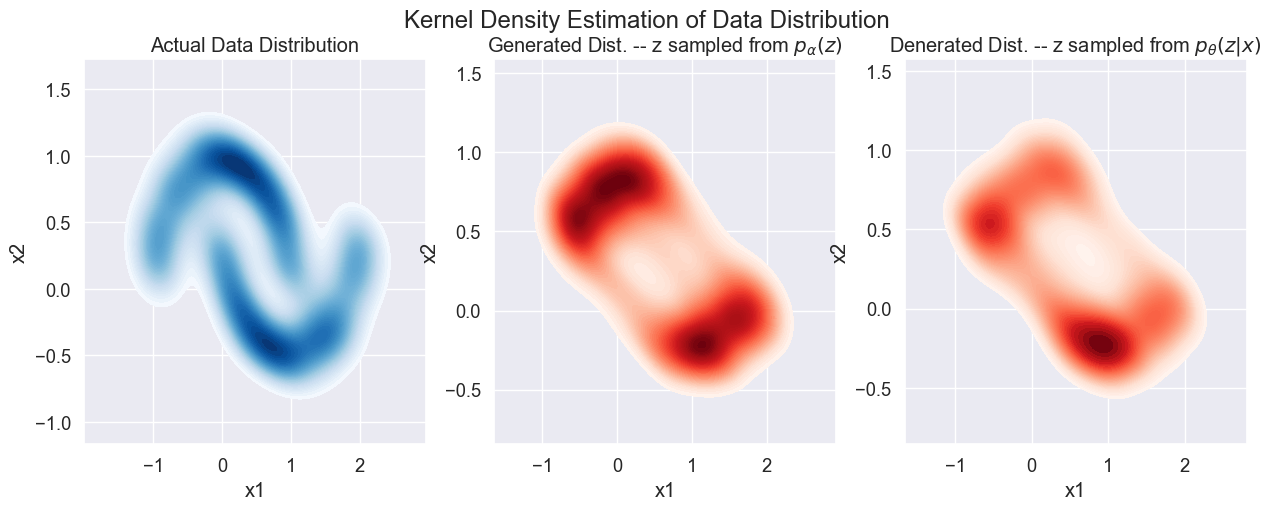

Clearly the model now learn correctly. The main benefit to writing out the code myself was enhancing my ability to troubleshoot. This is because I believe my code was implemented better than Pang's.

For example, my sampler was implemented agnostic to whichever distribution was being approximated:

```python
class langevin_sampler():
    class langevin_sampler:
        """
        A class for sampling from a distribution using Langevin dynamics.

        Args:
        - p0_sigma (float): the standard deviation of the initial prior distribution
        - batch_size (int): the number of samples to generate at once
        - num_latent_samples (int): the number of latent variables to produce during a sampling loop
        - device (str): the device to use for computation (e.g. 'cpu' or 'cuda')

        Methods:
        - get_sample(initial_sample, data, model, EBMmodel=None): generates a sample using Langevin dynamics
        - sample_p0(): generates a sample from the initial prior distribution
        """
    def __init__(self, p0_sigma, batch_size, num_latent_samples, device):
        self.device = device
        self.p0_sigma = p0_sigma
        self.batch_size = batch_size
        self.num_z = num_latent_samples

    def get_sample(self, initial_sample, data, model, EBMmodel = None):
        """
        MCMC sampling using Langevin dynamics. Is used to generated samples from both the exp-tilter prior and the posterior.

        Args:
            initial_sample (tensor): The initial sample before the loop begins.
            data (tensor): The training data, which is solely used in the gradient computation for the posterior sampling procedure.
            model (class): The model used for the sampling procedure. EBM for exp-tilter prior, Generator for posterior.
            EBMmodel (class): Used solely for the posterior sampling procedure. The EBM model is also used in calculation of the posterior gradient.

        Returns:
            x_k (tensor): The final sample
        """
        x_k = initial_sample
        
        step = 0
        
        while step < model.K:
            # Compute gradient
            grad = model.grad_log_fn(x_k, data, EBMmodel)
            
            # Update sample
            x_k = x_k + (model.s * model.s * grad) + (torch.sqrt(torch.tensor(2)) * model.s * torch.randn_like(x_k, device=self.device))  

            step += 1             
        
        return x_k
    
    def sample_p0(self):
        """
        Sample form the initial prior distribution.

        Returns:
            z0: A normally distributed variable
        """
        return self.p0_sigma * torch.randn(self.batch_size, self.num_z, device=self.device, requires_grad=True)
```

And instead, the grad-log-functions were contained specifically in the neural network models used to generate them:

Here is the EBM model used to generate the prior distribution:

```python
class tiltedpriorEBM(nn.Module):
    def __init__(self, input_dim, output_dim, p0_sigma, langevin_steps=20, langevin_s=0.4):
        super().__init__()
        
        self.s = langevin_s # This is s in langevin sampler
        self.K = langevin_steps # Number of steps the langevin sampler takes
        self.p0_sigma = p0_sigma # Standard deviation of z0
        
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                )
            
    def forward(self, z):
        # Returns f_a(z)
        return self.layers(z)
    
    def grad_log_fn(self, z, x, model):
        
        # Compute gradient of log p_a(x) w.r.t. z
        f_z = self.forward(z)
        grad_f_z = torch.autograd.grad(f_z.sum(), z, create_graph=True)[0] # Gradient of f_a(z)
        
        return grad_f_z - (z / (self.p0_sigma * self.p0_sigma)) # This is GRAD log[p_a(x)]
```

And here is the Generator model used to generate the posterior distribution:

```python
class topdownGenerator(nn.Module):
    def __init__(self, input_dim, output_dim, lkhood_sigma, langevin_steps=20, langevin_s=0.1):
        super().__init__()
        
        self.s = langevin_s # This is s in langevin sampler
        self.K = langevin_steps # Number of steps the langevin sampler takes
        self.lkhood_sigma = lkhood_sigma
        self.grad_log_prior = 0
        
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                )
    
    def forward(self, z):
        g_z = self.layers(z)
        return g_z
    
    def grad_log_fn(self, z, x, EBM_model):
        
        # Compute gradient of log[p(x | z)] w.r.t z
        g_z = self.forward(z)
        log_gz = -(torch.norm(x-g_z, dim=-1)**2) / (2.0 * self.lkhood_sigma * self.lkhood_sigma)
        grad_log_gz = torch.autograd.grad(log_gz.sum(), z, create_graph=True)[0]
        
        # Compute gradient of log[p(z)] w.r.t z
        f_z = EBM_model.forward(z)
        grad_f_z = torch.autograd.grad(f_z.sum(), z, create_graph=True)[0] # Gradient of f_a(z)
        grad_log_prior = grad_f_z - (z / (EBM_model.p0_sigma * EBM_model.p0_sigma))
        
        return grad_log_gz + grad_log_prior # This is GRAD log[ p(x | z) * p(z) ]
```

Here is an exemplar training use case:

```python
# 1a. Sample from latent prior p0(z)
z0_EBM = Sampler.sample_p0()
z0_GEN = Sampler.sample_p0()

# Samples z from p_a(z)
zK_EBM = Sampler.get_sample(z0_EBM, None, EBMnet, None)
# Sample z from p_theta(z|x)
zK_GEN = Sampler.get_sample(zK_EBM, x, GENnet, EBMnet)

# 2. Forward pass prediction, sample x from p_theta(x|z)
x_pred = GENnet(zK_GEN.detach()) + (GENnet.lkhood_sigma * torch.randn_like(x))
```

To generate samples, we assume that the model has trained to the extent that $p_\alpha(z)$ is matched to $p_\theta(z|x)$. Therefore, we can sample from gaussian noise and then pass that directly into the generator to generate x-samples. This is done in the following code:

```python
z = Sampler.sample_p0()
z_prior = Sampler.get_sample(z, None, EBMnet, None)
x_pred = GENnet(z_prior) 
```

Here is another set of results, to prove that it is reproducible:


### 20/11/2023

Spent last week working on my Michaelmas presentation. This was delivered today. Unfortunately, I think too much time was spent going over theory rather than discussing why my project is useful/the progress I have made thus far. Presenting the theory is necessary to understand the project, since a lot of my successes would not be understandable otherwise. However, the subject matter is far too complicated to present within 10 minutes. I will need to keep this in mind for my Lent presentation. Maybe I could try printing handouts?

### 21/11/2023

I have now finished modularising my implementation. I am also now training the model on MNIST.